# Intel Image Classification (CNN - Keras)

https://www.kaggle.com/datasets/puneet6060/intel-image-classification?datasetId=111880&sortBy=voteCount

# Import necessary packages

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ! cp /content/drive/MyDrive/datasets/dataset.zip /content
# ! unzip dataset.zip

# Loading the Data


In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (120, 120)

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['/content/dataset/seg_train/seg_train', '/content/dataset/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/dataset/seg_train/seg_train


100%|██████████| 2191/2191 [00:02<00:00, 861.59it/s]


Loading /content/dataset/seg_test/seg_test


100%|██████████| 437/437 [00:00<00:00, 789.83it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploring the dataset


In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


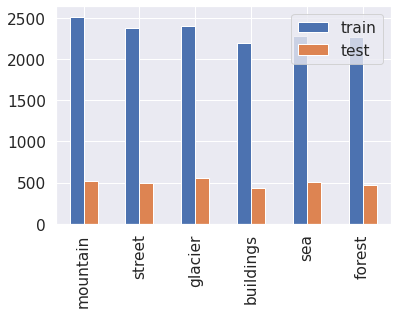

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

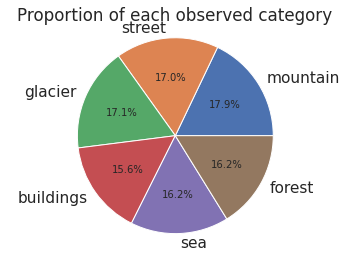

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## scaling the data

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualizing random data


In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

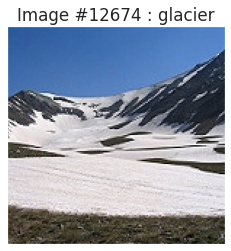

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

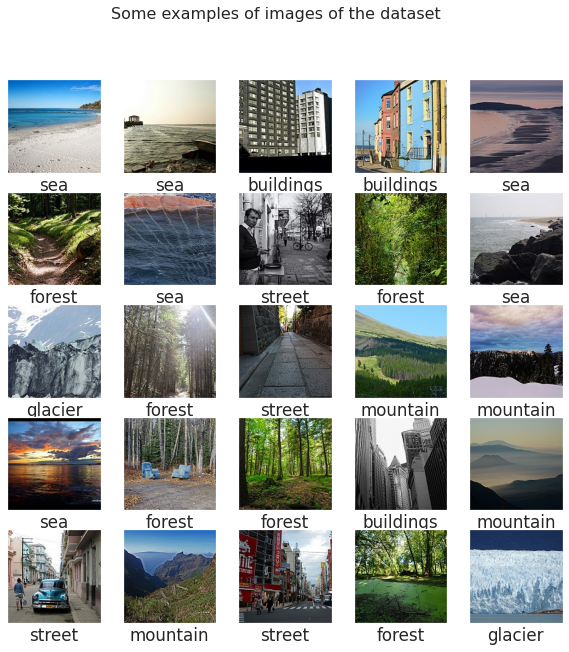

In [ ]:
display_examples(class_names, train_images, train_labels)

# Simple CNN Model

Layers:

* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [ ]:
history = model.fit(train_images, train_labels, batch_size=16, epochs=20, validation_split = 0.2)

Epoch 1/20
702/702 [==============================] - 23s 16ms/step - loss: 0.9117 - accuracy: 0.6572 - val_loss: 0.7014 - val_accuracy: 0.7481
Epoch 2/20
702/702 [==============================] - 9s 13ms/step - loss: 0.5680 - accuracy: 0.7949 - val_loss: 0.6374 - val_accuracy: 0.7823
Epoch 3/20
702/702 [==============================] - 10s 14ms/step - loss: 0.3617 - accuracy: 0.8714 - val_loss: 0.7386 - val_accuracy: 0.7535
Epoch 4/20
702/702 [==============================] - 9s 13ms/step - loss: 0.1821 - accuracy: 0.9388 - val_loss: 0.8917 - val_accuracy: 0.7517
Epoch 5/20
702/702 [==============================] - 9s 13ms/step - loss: 0.1070 - accuracy: 0.9662 - val_loss: 1.0650 - val_accuracy: 0.7506
Epoch 6/20
702/702 [==============================] - 9s 13ms/step - loss: 0.0706 - accuracy: 0.9784 - val_loss: 1.3173 - val_accuracy: 0.7342
Epoch 7/20
702/702 [==============================] - 9s 14ms/step - loss: 0.0645 - accuracy: 0.9810 - val_loss: 1.2397 - val_accuracy: 0.74

In [ ]:
# model.save('/content/model1')

INFO:tensorflow:Assets written to: /content/model1/assets


INFO:tensorflow:Assets written to: /content/model1/assets


##As we can see above the model validation accuracy stagnates at around 0.76 because the model is simple with less layers and parameters

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

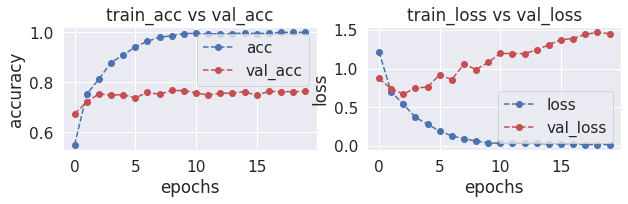

In [ ]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 12ms/step - loss: 1.7996 - accuracy: 0.7667


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

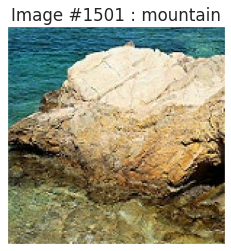

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


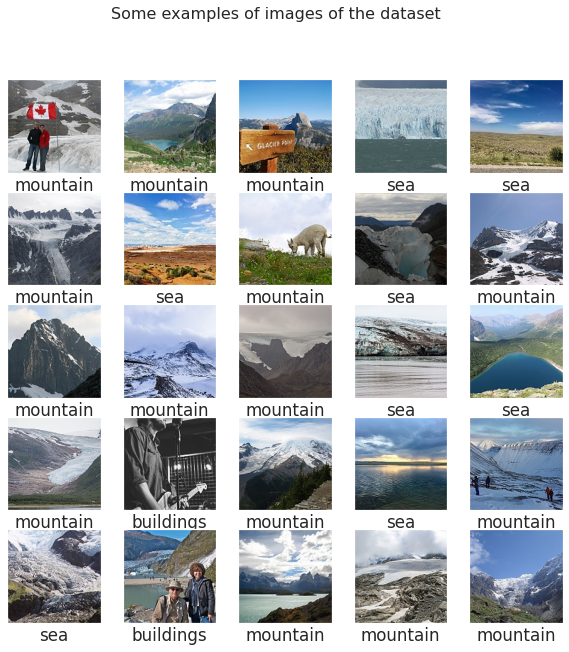

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

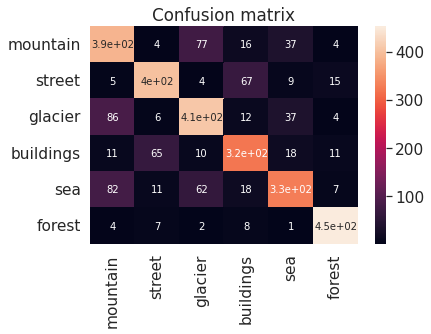

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## We see that classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. It can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well.
However, it can detects forest very accurately!

# Feature extraction with VGG ImageNet

In [18]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

Get the features directly from VGG16

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 7ms/step - loss: 0.5937 - accuracy: 0.7866 - val_loss: 0.4183 - val_accuracy: 0.8461
Epoch 2/15
88/88 [==============================] - 0s 5ms/step - loss: 0.3600 - accuracy: 0.8741 - val_loss: 0.3776 - val_accuracy: 0.8579
Epoch 3/15
88/88 [==============================] - 0s 5ms/step - loss: 0.3012 - accuracy: 0.8948 - val_loss: 0.3924 - val_accuracy: 0.8564
Epoch 4/15
88/88 [==============================] - 0s 5ms/step - loss: 0.2721 - accuracy: 0.9057 - val_loss: 0.3765 - val_accuracy: 0.8596
Epoch 5/15
88/88 [==============================] - 0s 6ms/step - loss: 0.2465 - accuracy: 0.9124 - val_loss: 0.3888 - val_accuracy: 0.8586
Epoch 6/15
88/88 [==============================] - 0s 5ms/step - loss: 0.2180 - accuracy: 0.9251 - val_loss: 0.3964 - val_accuracy: 0.8546
Epoch 7/15
88/88 [==============================] - 0s 6ms/step - loss: 0.1963 - accuracy: 0.9333 - val_loss: 0.3992 - val_accuracy: 0.8568
Epoch 8/15
88/88 [==

### We can see that accuracy is 0.85 for validation data which is pretty good.

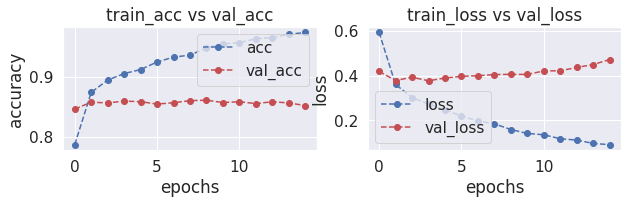

In [ ]:
plot_accuracy_loss(history2)

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 0.4511 - accuracy: 0.8547
